#Libraries

In [15]:
!pip install deap
import numpy as np
import random
from deap import base, creator, benchmarks
import matplotlib.pyplot as plt
import time
from scipy import stats
from abc import ABC, abstractmethod

# parameters

In [621]:
central_point_function_name = "randomized_weighted_mean"  # Check possible names below in 'possible_central_point_functions'
obj_func = "rastrigin"  # Check possible names below in 'possible_obj_func'
dim = 2 # dimension of the objective function

population_size=1000  # Int, the size of the population
num_generations = 500  # num_generations: Int, the number of generations
sigma = 0.7  # float [0, 1], scaling factor that controls the size of the steps the algorithm

proportion_to_cut = 0.1  #float [0, 1] Parameter used if you are using central point trimmed_mean or trimmed_median

## Validation Params

In [622]:
possible_central_point_functions = ['mean', 'weight_mean', 'median', 'trimmed_mean', 'trimmed_median', 'randomized_weighted_mean']
if central_point_function_name not in possible_central_point_functions:
  raise Exception(f"Wrong parameter as defining central point, received: {central_point_function_name}, possible: {possible_central_point_functions}")
possible_obj_func = ['sphere', 'rastrigin', 'rosenbrock', 'ackley', 'griewank', 'schwefel', 'himmelblau']
if obj_func not in possible_obj_func:
  raise Exception(f"Wrong parameter as defining objective function, received: {obj_func}, possible: {possible_obj_func}")

# CMA-ES

## Definition of central point

In [623]:
def weight_mean_point(selected, weights):
  return np.dot(weights, selected)


def mean_point(selected, weights):
  return np.mean(selected, axis=0)


def median(selected, weights):
    return np.median(selected, axis=0)

def trimmed_mean(selected, weights):
    return stats.trim_mean(selected, proportion_to_cut, axis=0)

def trimmed_median(selected, weights):
    sorted_selected = np.sort(selected, axis=0)
    cut_off = int(proportion_to_cut * len(sorted_selected))
    trimmed = sorted_selected[cut_off:-cut_off]
    return np.median(trimmed, axis=0)

def randomized_weighted_mean(selected, weights):
    random_weights = np.random.rand(len(selected))
    random_weights /= sum(random_weights)
    return np.average(selected, axis=0, weights=random_weights)

In [624]:
central_point_mapper = {
    "mean": mean_point,
    "weight_mean": weight_mean_point,
    "median": median,
    "trimmed_mean": trimmed_mean,
    "trimmed_median": trimmed_median,
    "randomized_weighted_mean": randomized_weighted_mean
}

In [625]:
def central_point_function():
  return central_point_mapper[central_point_function_name]

## Definition of the objective function

In [626]:
def get_obj_function_and_bounds(name, dimension=2):
    """Returns the function and its associated bounds based on the given name."""
    functions = {
        "sphere": (lambda x: -benchmarks.sphere(x)[0], [0, 10]),
        "rastrigin": (lambda x: -benchmarks.rastrigin(x)[0], [-5.12, 5.12]),
        "rosenbrock": (lambda x: -benchmarks.rosenbrock(x)[0], [-2.048, 2.048]),
        "ackley": (lambda x: -benchmarks.ackley(x)[0], [-32.768, 32.768]),
        "griewank": (lambda x: -benchmarks.griewank(x)[0], [-600, 600]),
        "schwefel": (lambda x: -benchmarks.schwefel(x)[0], [-500, 500]),
        "himmelblau": (lambda x: -benchmarks.himmelblau(x)[0], [-6, 6])
    }

    func, single_dim_bounds = functions[name]
    # Expand the bounds to the specified number of dimensions, except for inherently 2D functions
    if name in ["himmelblau", "booth"] and dimension != 2:
        raise ValueError(f"{name} function is typically a 2D function.")

    bounds = [single_dim_bounds] * dimension  # Create a list of bounds for each dimension
    return func, bounds

# CMA-ES definition

In [627]:
class EvolutionInterface(ABC):
  def __init__(self, objective_function, bounds, central_point_function, population_size, num_generations):
        self.objective_function = objective_function
        self.bounds = bounds
        self.central_point_function = central_point_function
        self.population_size = population_size
        self.num_generations = num_generations
        self.dimension = len(bounds)  # The length of bounds should determine the number of dimensions.

  @abstractmethod
  def run():
    pass


In [628]:
class CMAES(EvolutionInterface):
    def __init__(self, objective_function, bounds, central_point_function, population_size, num_generations, sigma):
        super().__init__(objective_function, bounds, central_point_function, population_size, num_generations)
        self.sigma = sigma
        self.mean = np.random.uniform([b[0] for b in bounds], [b[1] for b in bounds])
        self.C = np.identity(self.dimension)  # Initial covariance matrix
        self.mueff = population_size  # Effective population size (simplified)


    def initialize_population(self):
        """Generate an initial population using a multivariate normal distribution."""
        return np.random.multivariate_normal(self.mean, self.sigma**2 * self.C, self.population_size)

    def evaluate_population(self, population):
        """Evaluate a population using the objective function."""
        return np.array([self.objective_function(ind) for ind in population])

    def update_distribution(self, population, fitness):
      # Calculate weights for only the top 50% of individuals
      num_selected = int(self.population_size / 2)
      weights = np.array([np.log(num_selected/2 + 1) - np.log(i+1) if i < num_selected/2 else 0 for i in range(num_selected)])
      weights /= np.sum(weights)  # Normalize the weights

      sorted_indices = np.argsort(-fitness)
      selected = population[sorted_indices][:num_selected]

      # Only apply weights to selected individuals
      new_mean = self.central_point_function(selected, weights)
      z = (selected - self.mean) / self.sigma
      z_weighted = np.dot(np.diag(weights), z)
      new_C = np.dot(z.T, z_weighted)

      # Update parameters
      self.mean = new_mean
      self.C = (1 - 1/self.population_size) * self.C + (1/self.population_size) * new_C


    def run(self):
        """Run the CMA-ES algorithm."""
        population = self.initialize_population()
        fitness_history = []

        for generation in range(self.num_generations):
            fitness = self.evaluate_population(population)
            fitness_history.append(np.max(fitness))
            self.update_distribution(population, fitness)
            population = np.random.multivariate_normal(self.mean, self.sigma**2 * self.C, self.population_size)
            print(f"Generation {generation}: Max fitness = {np.max(fitness)}")

        return population, fitness_history

# Experiments

In [629]:
#Pojedyńcze wywołanie
objective_function, bounds = get_obj_function_and_bounds(obj_func, dim)

# Create CMA-ES instance with custom central point function
cmaes = CMAES(objective_function, bounds, central_point_function(), population_size, num_generations, sigma)
start_time = time.perf_counter()
single_final_population, single_fitness_history = cmaes.run()
end_time = time.perf_counter()

Generation 0: Max fitness = -0.10671132074486778
Generation 1: Max fitness = -0.10539203122504404
Generation 2: Max fitness = -0.8961981939095516
Generation 3: Max fitness = -0.14375482112857796
Generation 4: Max fitness = -0.34772516629371353
Generation 5: Max fitness = -0.5167446314121378
Generation 6: Max fitness = -0.10858677072191725
Generation 7: Max fitness = -0.009306832677111743
Generation 8: Max fitness = -0.26052370744157827
Generation 9: Max fitness = -0.09876278439200803
Generation 10: Max fitness = -0.20019847459310824
Generation 11: Max fitness = -0.3663426771944174
Generation 12: Max fitness = -0.08381850761938381
Generation 13: Max fitness = -0.6737228305000187
Generation 14: Max fitness = -0.0053168210671330485
Generation 15: Max fitness = -0.08496105985789981
Generation 16: Max fitness = -0.5796950936510115
Generation 17: Max fitness = -0.029880350864146976
Generation 18: Max fitness = -0.04159634767311715
Generation 19: Max fitness = -0.05387570750437831
Generation 

In [630]:
# Funkcja, która uruchamia algorytm CMA-ES 15 razy i zwraca uśrednione wyniki
def run_multiple_times(objective_function, bounds, central_point_function, population_size, num_generations, sigma, num_runs=15):
    fitness_histories = []
    execution_times = []

    print("Wyniki każdego z wywołań:")
    print("\n")
    for _ in range(num_runs):
        print("\n")
        cmaes = CMAES(objective_function, bounds, central_point_function(), population_size, num_generations, sigma)
        start_time = time.perf_counter()
        final_population, fitness_history = cmaes.run()
        end_time = time.perf_counter()

        fitness_histories.append(fitness_history)
        execution_times.append(end_time - start_time)

        print(execution_times)

    # Obliczanie średniej wartości przystosowania i czasu wykonania
    avg_fitness_history = np.mean(fitness_histories, axis=0)
    avg_execution_time = np.mean(execution_times)

    return avg_fitness_history, avg_execution_time

# Uruchomienie algorytmu CMA-ES 15 razy
avg_fitness_history, avg_execution_time = run_multiple_times(objective_function, bounds, central_point_function, population_size, num_generations, sigma)

# Wyświetlenie średniej wartości przystosowania

print("Wynik uśredniony z 15 wywołań: ")
print("\n")
for i, fitness in enumerate(avg_fitness_history):
    print(f"Generation {i}: Max fitness = {fitness}")

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
Generation 28: Max fitness = -0.007009822902894314
Generation 29: Max fitness = -0.19551366749853827
Generation 30: Max fitness = -0.5265856513216747
Generation 31: Max fitness = -0.031239020109040894
Generation 32: Max fitness = -0.1628265696929425
Generation 33: Max fitness = -0.28971486500423893
Generation 34: Max fitness = -0.09280218343496216
Generation 35: Max fitness = -0.10869912171450125
Generation 36: Max fitness = -0.12814057436521153
Generation 37: Max fitness = -0.16948058327760762
Generation 38: Max fitness = -0.09594836691310604
Generation 39: Max fitness = -0.22644927291490546
Generation 40: Max fitness = -0.06590893154207578
Generation 41: Max fitness = -0.014426083138058488
Generation 42: Max fitness = -0.21959202696952573
Generation 43: Max fitness = -0.18257828437568335
Generation 44: Max fitness = -0.30495990624322644
Generation 45: Max fitness = -0.16078742946038815
Generation 46: Max fitness = -0.50

# Analyze

Time of the evaluation: 7.029495525999664


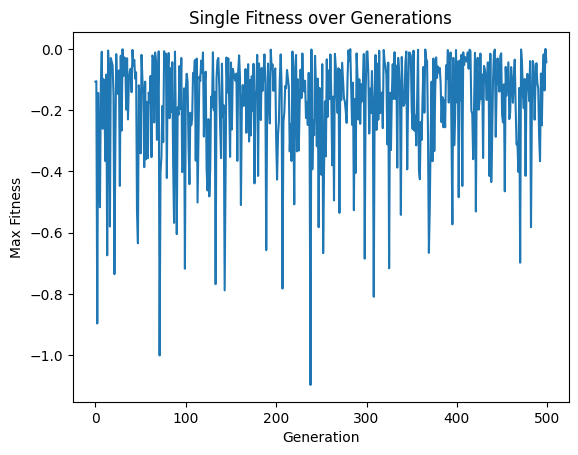

In [631]:
# Pojedyńczy wynik
try:
  print("Time of the evaluation:", end_time-start_time)
except Exception:
  print("Cannot calculate time of execution because execution was stopped by force and it was not completed so there is no ending time")
plt.plot(single_fitness_history)
plt.title('Single Fitness over Generations')
plt.xlabel('Generation')
plt.ylabel('Max Fitness')
plt.show()

Average Time of the evaluation: 6.132531048266295


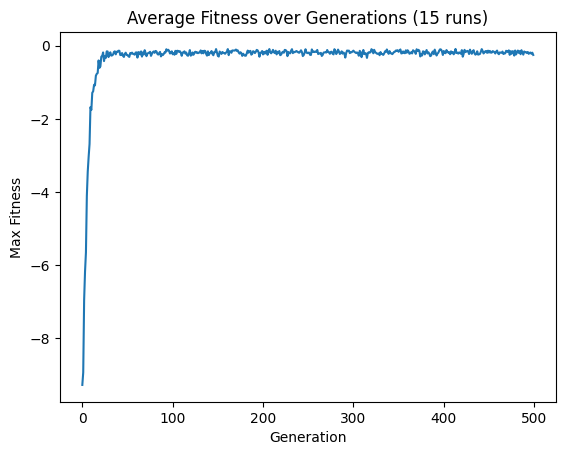

In [632]:
# uśrednione wyniki
try:
  print("Average Time of the evaluation:", avg_execution_time)
except Exception:
  print("Cannot calculate time of execution because execution was stopped by force and it was not completed so there is no ending time")

plt.plot(avg_fitness_history)
plt.title('Average Fitness over Generations (15 runs)')
plt.xlabel('Generation')
plt.ylabel('Max Fitness')
plt.show()